In [3]:
%matplotlib inline 
import numpy as np
import emcee
import matplotlib.pyplot as plt
import phoebe
import matplotlib.mlab as mlab
from matplotlib.pyplot import cm 

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [4]:
def rpars(init_dist):
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

def lnprior(priors, values):
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

def lnprob(z):

#     mod['incl@binary@orbit@component'] = z[0]
#     mod['requiv@primary@star@component'] = z[1]
#     mod['requiv@secondary@star@component'] = z[2]
#     mod['q@binary@orbit@component'] = z[3]
    #params is list of parameters to be fitted for
    params=[mod['period@orbit'], mod['t0_supconj@binary@component'],\
            mod['teff@primary'], mod['teff@secondary']]
    for x in range(len(params)):
        params[x]=z[x]
    
    lnp = lnprior(priors,z)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigmas**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf
    
def run(init_dist, nwalkers, niter):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in xrange(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        plt.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = plt.hist(y, 200, normed=1, color="b", alpha=0.45)#, histtype="step")
        plt.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print "mu = ", mu
        print "sigma = ",sigmas

        bf = mlab.normpdf(bins, mu, sigma)
        l = plt.plot(bins, bf, 'k--', linewidth=2.0)
    plt.show()
    return pos

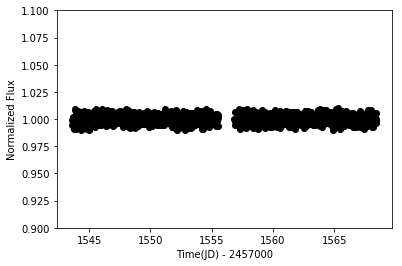

In [5]:
LC_df = pd.read_csv("Flat_LC.txt")

T=np.array(LC_df['time'].to_list())
F=np.array(LC_df['Flux'].to_list())
E=np.array(LC_df['Error'].to_list())

plt.plot(T- 2457000,F,'ko',linestyle='none')
plt.xlabel('Time(JD) - 2457000')
plt.ylabel('Normalized Flux')
plt.ylim(0.9,1.1)
plt.show()

In [6]:
print('number of data pts:', len(T))

('number of data pts:', 1073)


injecting EB


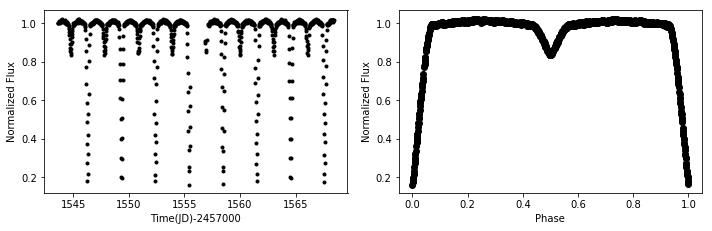

In [13]:
#make a new model to inject synthetic data
mod = phoebe.default_binary()

mod['t0_supconj@binary@component'] = np.random.uniform(0,5)
mod['period@orbit'] = np.random.uniform(1,(T[-1]-T[0])/3) #7.5
mod['sma@orbit'] = np.random.uniform(0.1,5) #5
mod['incl@orbit'] = 90.0
# mod['requiv@primary'] = 1.0
mod['teff@primary'] = 6000.
mod['requiv@primary'] = 0.6 #equal star
# mod['teff@primary'] = 4000.
mod['requiv@secondary'] = 0.6
mod['teff@secondary'] = 4000.

passband='Cousins:I' #is there a TESS one? Doesn't look like it...

mod.add_dataset('lc', times = T, fluxes=F, sigmas=E,passband=passband) #compute_phases=np.linspace(0,1.,51), passband=passband)

#reducing parameter space to run faster, LESS is faster(???)
# Ntriangles=300

Ntriangles=100 #100 is minimum

mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(Ntriangles)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(Ntriangles)

#Create Model
mod.run_compute()


model_t,model_f=mod['model@times'].value,mod['model@fluxes'].value

print('injecting EB')
injF= model_f-F+1
# injF= F - model_f+1
injF/=np.median(injF) #renormalizing (b/c Phoebe is weird?)


fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(221)
#Light Curve
ax1.plot(T-2457000,injF,'k.')
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Time(JD)-2457000')

#Phase Curve
def phasefold(T0,time,period,flux):
#     phase=(time- T0 + 0.5*period) % period - 0.5*period #for transits centered on T0
    phase=np.mod((time-T0)/period,1)
    ind=np.argsort(phase, axis=0)
    return phase[ind],flux[ind]


P=mod['period@orbit'].value
T0 =mod['t0_supconj@binary@component'].value #
# T0 =mod['t0_ref@binary@component'].value #<--- constrained, can't be overwritten


pf,ff=phasefold( T0 , T, P, injF)


ax2=fig.add_subplot(222)
ax2.plot(pf,ff,'ko')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Phase')
plt.tight_layout()
plt.show()


# print mod['t0_ref@binary@component'].value
# print mod['t0_supconj@binary@component'].value
# print mod['t0_perpass@binary@component'].value

# print mod['asini@binary@component'].value
# print mod['sma@binary@component'].value
# print mod['incl@binary@component'].value


In [14]:
# print(mod['star'])

This is how model looks before fitting optimized parameters
(An initial guess)
injecting EB


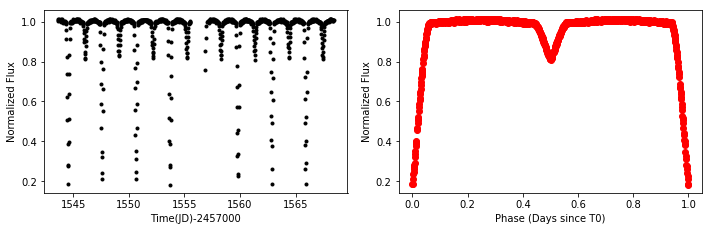

In [15]:
#make a new model to fit synthetic data
mod = phoebe.default_binary()

passband='Cousins:I' #is there a TESS one? Doesn't look like it...

mod.add_dataset('lc', times = T, fluxes=injF, sigmas=E,passband=passband) #compute_phases=np.linspace(0,1.,51), passband=passband)

#putting in priors (let's say we're off a little bit on these...)
mod['period@orbit'] = P+0.25/24.0
mod['incl@orbit'] = 90.0
mod['teff@primary'] = (6000.-100)
mod['teff@secondary'] = (4000.+100)

#reducing parameter space to run faster, LESS triangles is faster but less correct(???)
Ntriangles=300
# Ntriangles=100 #100 is minimum

mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(Ntriangles)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(Ntriangles)

#Create Model
print('This is how model looks before fitting optimized parameters')
print('(An initial guess)')
mod.run_compute()
# mod.plot(show=True)

model_t,model_f=mod['model@times'].value,mod['model@fluxes'].value

print('injecting EB')
injF= model_f - F+1
injF/=np.median(injF) #renormalizing (b/c Phoebe is weird?)


fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(221)
#Light Curve
ax1.plot(T-2457000,injF,'k.')
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Time(JD)-2457000')

#Phase Curve


pf,ff =phasefold( mod['t0_supconj@binary@component'].value , T, mod['period@orbit'].value, injF)


ax2=fig.add_subplot(222)


ax2.plot(pf,ff,'ro')
ax2.set_ylabel('Normalized Flux')
ax2.set_xlabel('Phase (Days since T0)')
plt.tight_layout()
plt.show()

mu =  3.0459334190901433
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]


/Users/felizd/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu =  4.717431605168207
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]
mu =  6006.999126649057
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]
mu =  4032.9338759416733
sigma =  [0.01123394 0.01483429 0.01617319 ... 0.02998139 0.02912604 0.02922774]


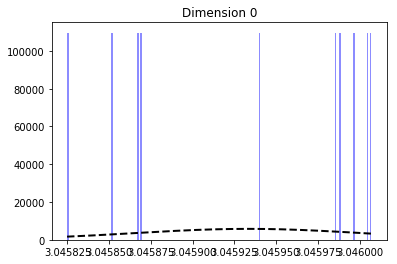

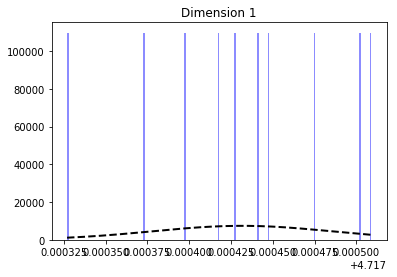

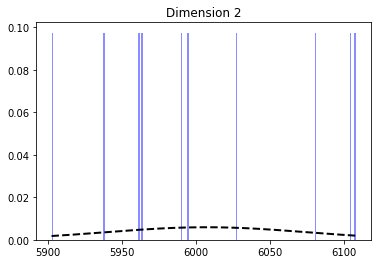

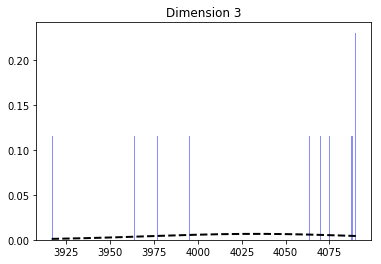

('runtime :', 13.370505531628927, ' minutes')


In [16]:
times=T
fluxes=injF
sigmas=E


#making hyperparameters
nwalkers = 10
niter = 3

#Now we have our data, we need to set the hyperparamters required to run emcee. 
#Here the prior boxes provide the lower and upper limits for the phoebe parameter values. 

#prior width for range of parameter space to search
Period_prior_width=0.0001 #in days
Teff_prior_width=50*2.5
T0_prior_width= 0.0001 #0.1/24.0 # in hours


Period_min,Period_max = P-Period_prior_width, P+Period_prior_width #days
Teff_primary_min,Teff_primary_max = 6000-Teff_prior_width, 6000+Teff_prior_width
Teff_secondary_min,Teff_secondary_max = 4000-Teff_prior_width, 4000+Teff_prior_width
T0_min,T0_max = T0-T0_prior_width ,T0+T0_prior_width 

# We will select the starting point in parameter space
# with the order of parameters

#Try fitting only Period and T0 and primary/secondary temperatures (P,T0,T1,T2)
init_dist = [(Period_min,Period_max),(T0_min,T0_max), \
             (Teff_primary_min,Teff_primary_max),(Teff_secondary_min,Teff_secondary_max)]

#Here we will set uninformed priors, but you can have informed priors such as gaussian priors:
priors = init_dist #keep it the same? 

labels=['Period','T0 Ref','Teff Primary','Teff Secondary']
import time as timer

start=timer.time()
pos = run(init_dist, nwalkers, niter)#, labels)
runtime = (timer.time()-start)/60.0
print('runtime :',runtime,' minutes')


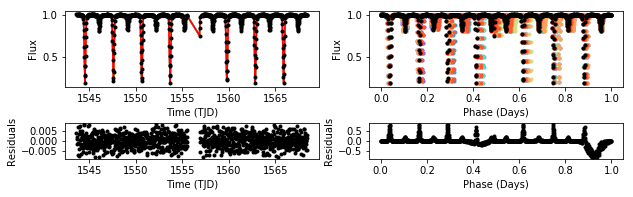

In [17]:
color=cm.rainbow(np.linspace(0,1,nwalkers))

fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

#phase folding
# pf=phasefold( 0 , T, 7.5) #using correct T0 and correct P

for i,c in zip(range(nwalkers),color):
  
    #pl.figure()
    
    # Set all the parameter values being fit
#     mod['incl@binary@orbit@component'] = pos[-1-i,0]
#     mod['period@orbit'] = pos[-1-i,1]
#     mod['teff@primary'] = pos[-1-i,2]
#     mod['teff@secondary'] = pos[-1-i,3]

    mod['period@orbit'] = pos[-1-i,0]
    mod['t0_supconj@binary@component']  = pos[-1-i,1]
    mod['teff@primary'] = pos[-1-i,2]
    mod['teff@secondary'] = pos[-1-i,3]
    
    T0_fit=mod['t0_supconj@binary@component'].value
    Per_fit=mod['period@orbit'].value
    
#     mod['incl@binary@orbit@component'] = pos[-1-i,0] #inclination
#     mod['requiv@primary@star@component'] = pos[-1-i,1] #requiv 1
#     mod['requiv@secondary@star@component'] = pos[-1-i,2] #requiv 2
#     mod['q@binary@orbit@component'] = pos[-1-i,3] #mass ratio primary:secondary
        
    mod.run_compute(model='run{}'.format(i))
    
    model = mod['fluxes@latest@model'].get_value()
    model/=np.median(model) #normalizing
    ax1.plot(T-2457000,model,c=c)
    
    pf,ff=phasefold( T0_fit , T, Per_fit,injF) #using fitted T0 and fitted P
    
    ax2.plot(pf,model,c=c,marker='.',linestyle='none')
    
    

ax1.set_xlabel("Time (TJD)")
ax1.set_ylabel("Flux")
ax1.plot(T-2457000,injF,"k.")
# frame1=ax1.add_axes((.1,.3,.8,.6))
ax2.set_xlabel("Phase (Days)")
ax2.set_ylabel("Flux")
ax2.plot(pf,injF,"k.")


size,pad=0.5,0.5
divider = make_axes_locatable(ax1)
ax1b = divider.append_axes("bottom", size=size, pad=pad)
ax1.figure.add_axes(ax1b)
ax1b.plot(T-2457000,injF-model,'k.')
ax1b.set_ylabel('Residuals')
ax1b.set_xlabel('Time (TJD)')

divider = make_axes_locatable(ax2)
ax2b = divider.append_axes("bottom", size=size, pad=pad)
ax2.figure.add_axes(ax2b)
pf,ff=phasefold( T0_fit , T, Per_fit,injF) #using correct T0 and correct P
ax2b.plot(pf,ff-model,'k.')
ax2b.set_ylabel('Residuals')
ax2b.set_xlabel("Phase (Days)")

plt.show()   


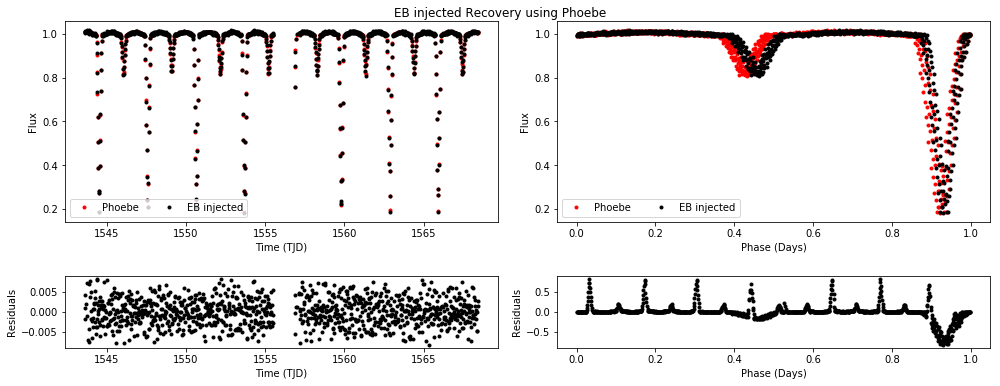

('T0s: ', 4.717414732742825, 4.717474576763302, '% difference: ', 0.0012685766223076744)
('Periods: ', 3.0459235427597044, 3.0459858465818193, '% difference: ', 0.002045482141628453)
priors
('P prior:', 0.0001)
('Teff prior:', 125.0)
('T0 prior:', 0.0001)


In [22]:

pf,ff=phasefold( T0_fit , T, Per_fit,injF) #using fitted T0 and fitted P
pftrue,fftrue=phasefold( T0 , T, P,injF) #using correct T0 and correct P

fig=plt.figure(figsize=(14,10))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

model = mod['fluxes@latest@model'].get_value()
model/=np.median(model) #normalizing
ax1.plot(T-2457000,model,'r.',label='Phoebe')




ax1.set_xlabel("Time (TJD)")
ax1.set_ylabel("Flux")
ax1.plot(T-2457000,injF,"k.",label='EB injected')
# frame1=ax1.add_axes((.1,.3,.8,.6))
ax2.set_xlabel("Phase (Days)")
ax2.set_ylabel("Flux")


size,pad=1,0.75,#0.75
divider = make_axes_locatable(ax1)
ax1b = divider.append_axes("bottom", size=size, pad=pad)
ax1.figure.add_axes(ax1b)
ax1b.plot(T-2457000,injF-model,'k.',label='EB injected')
ax1b.set_ylabel('Residuals')
ax1b.set_xlabel('Time (TJD)')
# ax1b.set_ylim(np.min(injF-model)-0.01,np.max(injF-model)+0.01)

divider = make_axes_locatable(ax2)
ax2b = divider.append_axes("bottom", size=size, pad=pad)
ax2.figure.add_axes(ax2b)

ax2.plot(pf,ff,'r.',label='Phoebe')
ax2.plot(pftrue,ff,"k.",label='EB injected')
ax2b.plot(pftrue,ff-model,'k.')

ax2b.set_ylabel('Residuals')
ax2b.set_xlabel("Phase (Days)")
# ax2b.set_ylim(np.min(injF-model)-0.01,np.max(injF-model)+0.01)

ax1.legend(loc='lower left',ncol=2)
ax2.legend(loc='lower left',ncol=2)
fig.suptitle('EB injected Recovery using Phoebe',y=1)
plt.tight_layout()
plt.savefig('Phoebe_test.png',bbox_inches='tight')
plt.show()   


def change_percent(current,previous): 
    return ((float(current)-previous)/previous)*100

# print(len(T),len(model),len(F))
print('T0s: ', T0, T0_fit, '% difference: ',change_percent(T0_fit,T0))
print('Periods: ',P, Per_fit, '% difference: ',change_percent(Per_fit,P))

print('priors')
print('P prior:',Period_prior_width)
print('Teff prior:',Teff_prior_width)
print('T0 prior:',T0_prior_width)

